In [ ]:
import os
import torch
import torch.nn as nn
os.environ["KERAS_BACKEND"] = "torch"
import keras
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split


# Paths to the data directories
image_dir = os.path.expanduser(r"~/Documents/datasetz/datasets/cracktree200/Images")
mask_dir = os.path.expanduser(r"~/Documents/datasetz/datasets/cracktree200/Masks")

# Get list of image and mask file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Split data
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Custom Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Define transforms
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

# Set batch size for flexibility
batch_size = 8  # Change this value as needed

# Create Datasets and DataLoaders
train_dataset = SegmentationDataset(train_images, train_masks, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define UNet Model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())
        
        # Decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        
        # Output
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e1p = self.pool1(e1)
        
        e2 = self.encoder2(e1p)
        e2p = self.pool2(e2)
        
        b = self.bottleneck(e2p)
        
        d2 = self.upconv2(b)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)
        
        return torch.sigmoid(self.conv_last(d1))

model = UNet().cuda()




/home/crackscope/miniconda3/envs/road_anomaly_detector/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/crackscope/miniconda3/envs/road_anomaly_detector/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:

# Dice Loss function
def dice_loss(pred, target, smooth=1e-5):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return 1 - dice.mean()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training Loop with model saving
num_epochs = 50
#model_save_path = "unet_segmentation_model.pth"  # Path to save the trained model
model_save_path = "unet_segmentation_model_cracktree200.pth"  # Path to save the trained model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch [1/50], Loss: 0.9694533795118332
Epoch [2/50], Loss: 0.9694347729285558
Epoch [3/50], Loss: 0.9693522155284882
Epoch [4/50], Loss: 0.9694320807854334


KeyboardInterrupt: 

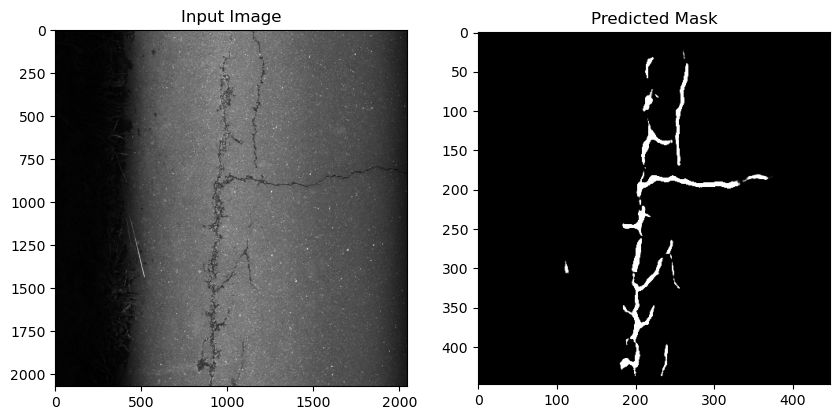

In [ ]:

# Inference function
def run_inference(model, image_path, transform=transform):
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert("L")
        input_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU
        output = model(input_tensor)
        output = output.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
        return output  # Returns the output mask as a NumPy array

# Example usage for inference
# Replace 'sample_image_path' with an actual path to an image you want to test
sample_image_path = '/home/crackscope/Road-Anomaly-Detector/road_anomaly_detector/main/model/test_images/exposure_25_outdoor_pavement_cropped.png'
output_mask = run_inference(model, sample_image_path)

# Displaying the result using matplotlib (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(Image.open(sample_image_path).convert("L"), cmap='gray')

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(output_mask, cmap='gray')
plt.show()

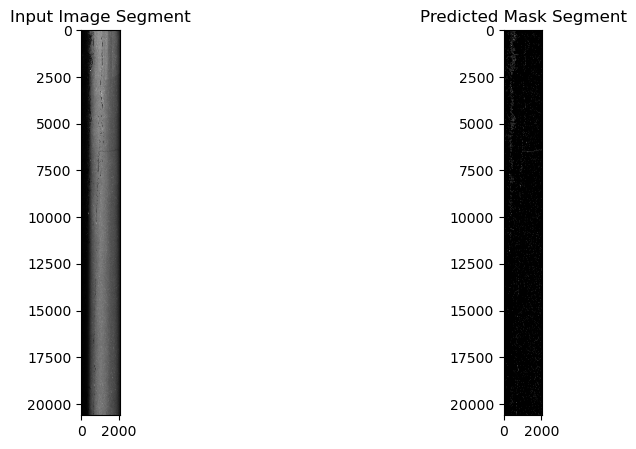

In [ ]:
def load_large_image(image_path, width=2048):
    """
    Load a large image with a fixed width and variable height.
    Returns the image in grayscale mode as a NumPy array.
    """
    image = Image.open(image_path).convert("L")
    image_np = np.array(image)
    return image_np

def sliding_window_inference(model, image_np, patch_height=448, overlap=0):
    """
    Perform inference on large images using a sliding window approach.

    Parameters:
    - model: Trained PyTorch model
    - image_np: NumPy array of the image (grayscale)
    - patch_height: Height of each patch to process
    - overlap: Number of pixels to overlap between patches

    Returns:
    - Full segmentation mask for the original image
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get the original image height
    height, width = image_np.shape
    full_mask = np.zeros_like(image_np, dtype=np.float32)
    
    # Sliding window loop
    step = patch_height - overlap
    for start_y in range(0, height, step):
        end_y = min(start_y + patch_height, height)  # Ensure we don't exceed the image height
        patch = image_np[start_y:end_y, :]

        # Resize patch if it's smaller than the patch_height due to reaching the bottom of the image
        if patch.shape[0] < patch_height:
            padded_patch = np.zeros((patch_height, width), dtype=np.float32)
            padded_patch[:patch.shape[0], :] = patch
            patch_tensor = torch.tensor(padded_patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()
        else:
            patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()

        # Run inference
        with torch.no_grad():
            output = model(patch_tensor)
        
        # Remove batch and channel dimensions, and move to CPU
        output_np = output.squeeze().cpu().numpy()

        # If patch was padded, remove the padding from the output
        if patch.shape[0] < patch_height:
            output_np = output_np[:patch.shape[0], :]

        # Store the output in the full mask
        full_mask[start_y:end_y, :] = output_np[:end_y - start_y, :]
        
        # Break if we've reached the bottom
        if end_y == height:
            break
    
    return full_mask

# Example usage
image_path = '/home/crackscope/Road-Anomaly-Detector/road_anomaly_detector/main/model/test_images/exposure_25_outdoor_pavement_cropped.png'
image_np = load_large_image(image_path)
full_mask = sliding_window_inference(model, image_np)

# Visualize result (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image Segment")
plt.imshow(image_np, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Predicted Mask Segment")
plt.imshow(full_mask, cmap="gray")
plt.show()